In [1]:
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from funcs_support import area_mean

In [2]:
dir_list_df = pd.read_csv('/user/ab5405/summeraliaclimate/code/dir_list.csv', index_col=0)
dir_list = dir_list_df['dir_path'].to_dict()

In [3]:
from funcs_support import get_filepaths

df_paths = get_filepaths(source_dir='proc', dir_list=dir_list)

In [4]:
df = df_paths.query("varname == 'tasdmgfparams' and gwl == 'ALLGWLs'").copy()

In [5]:
ds_check = xr.open_zarr(df['path'].iloc[0])
print(ds_check['bins_behrer'].coords['gwl'].values)

[0.61 1.   1.5  2.   2.5  3.  ]


In [6]:
def rebin_temp_data_mortality(da):
    
    #creates new edges of the bins from >10, 10-100, <100, in intervals of 10F. Then, calculate the midpoints of the bins 
    edges_F = np.concatenate(([-np.inf], np.arange(10, 100, 10), [np.inf]))
    mid_F = (edges_F[:-1] + edges_F[1:]) / 2
    
    mort_coeffs = [0.69,0.59,0.64,0.36,0.27,0.00,0.12,0.23,0.33,0.94]
    
    #creates an array with the mortality coeffs, and labels the 1D dim 'bin10F'. Then, attaches two coordinates,
    #one with just integer labels, and one that denotes the actual midpoints in farenheit. Names the array.
    dmgf_10F = xr.DataArray(mort_coeffs, dims=['bin10F'], coords={'bin10F':np.arange(10), 'mid_F_degF': ('bin10F', mid_F)},
    name='mortality_coeff')
    
    #grabs bins from ds and converts to F
    hist_bins_F = da['bin_f'].values * 9/5 - 459.67
    
    #maps each bin from the original data to the new coarse bins and assigns an integer count for which bin it belongs to
    hist_to_coarse_indicies = np.digitize(hist_bins_F, edges_F) - 1
    
    #Creates a data array from the 22-bins of the hist coarse data integers and wraps the integer index array into a 1-D 
    #array with dim bin_f. Then, selects from the damage function along the bin10F dimension the coeff that matches the integer 
        #this new hist now has an associated coefficient with each bin
    hist_fine = dmgf_10F.sel(bin10F = xr.DataArray(hist_to_coarse_indicies, dims='bin_f'))
    
    return hist_fine

In [7]:
def rebin_temp_data_gdp(da):
    
    #creates new edges of the bins from >-15, -15-31, <31, in intervals of 3C. Then, calculate the midpoints of the bins 
    edges_C = np.concatenate(([-np.inf], np.arange(-15, 31, 3), [ np.inf ]))
    mid_C   = (edges_C[:-1] + edges_C[1:]) / 2
    
    gdp_coeffs = [0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                    0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757]
    
    #creates an array with the gdp coeffs, and labels the 1D dim 'bin3C'. Then, attaches two coordinates,
    #one with just integer labels, and one that denotes the actual midpoints in C. Names the array.
    dmgf_dnh_3C = xr.DataArray(gdp_coeffs,dims=['bin3C'],coords={'bin3C':np.arange(len(gdp_coeffs)),'mid_C_degC': ('bin3C', mid_C)},name='gdp_loss_coeff')

    #grabs bins from ds and converts to C
    hist_bins_C = da['bin_f'].values - 273.15
    
    #maps each bin from the original data to the new coarse bins and assigns an integer count for which bin it belongs to
    hist_to_coarse_indicies = np.digitize(hist_bins_C, edges_C) - 1
    
    #Creates a data array from the 22-bins of the hist coarse data integers and wraps the integer index array into a 1-D 
    #array with dim bin_f. Then, selects from the damage function along the bin3C dimension the coeff that matches the integer 
    #this new hist now has an associated coefficient with each bin
    hist_fine = dmgf_dnh_3C.sel(bin3C = xr.DataArray(hist_to_coarse_indicies, dims='bin_f'))
    
    return hist_fine

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def calculate_impact_test(gwl):
    # 1) fresh lists for each call
    mort_impact_list = []
    gdp_impact_list  = []
    model_labels     = []
    run_labels       = []

    for i, row in df.iterrows():
        model_labels.append(row['model'])
        run_labels.append(row['run'])
    
        ds = xr.open_zarr(row['path'])

        gwl_delta = ds['bins_behrer'].sel(gwl=gwl,  method='nearest').transpose('bin_f','lat','lon')

        gwl_06    = ds['bins_behrer'].sel(gwl=0.61, method='nearest').transpose('bin_f','lat','lon')

        diff = gwl_delta - gwl_06
    
        # mortality
        mort_coef_fine = rebin_temp_data_mortality(diff)
        mort_map = (diff * mort_coef_fine).sum(dim='bin_f', skipna = False)
        mort_impact_list.append(mort_map)

        # GDP‐loss
        gdp_coef_fine = rebin_temp_data_gdp(diff)
        gdp_map_ln = (diff * gdp_coef_fine).sum(dim="bin_f", skipna=False)
        
        gdp_map = 100 * (np.exp(gdp_map_ln) - 1)
        gdp_map = gdp_map.compute()

        gdp_impact_list.append(gdp_map)
        
    mort_all = xr.concat(mort_impact_list, dim='run')
    gdp_all  = xr.concat(gdp_impact_list,  dim='run')
    mort_all = mort_all.assign_coords({'run': run_labels,'model': ('run', model_labels)})
    gdp_all  = gdp_all.assign_coords({'run':   run_labels,'model': ('run', model_labels)}) 
    
    return mort_all, gdp_all

In [9]:
def variability_partitioning(impact_all):
    
    #take the input (either mort_all or gdp_all), and take the mean over each run. Then, take the variance of the concatenated
    #impacts
    ensemble_mean   = impact_all.mean(dim='run',  skipna=False)
    total_var  = impact_all.var(dim='run',  skipna=False)
    
    #this finds the internal variability within each model over different runs
    within_model_var = impact_all.groupby('model').var(dim='run',  skipna=False)
    #finds mean internal variability over the dimension model (i.e. mean internal var across models)
    internal_var = within_model_var.mean(dim='model',  skipna=False)
    
    #this finds the mean impacts by model, for each run 
    model_means = impact_all.groupby('model').mean(dim='run', skipna=False)
    #this finds the variance in model means across models (i.e. model uncertainty)
    model_unc = model_means.var(dim='model', skipna=False)
    
    total_var = internal_var + model_unc
    f_internal = internal_var / total_var
    f_model = model_unc / total_var

    n_runs = impact_all.count(dim='run')
    f_internal = f_internal.where(n_runs >= 2)
    f_model    = f_model.where(n_runs >= 2)
    
    return xr.Dataset({
        "internal_variance": internal_var,
        "model_unc": model_unc,
        "total_variance": total_var,
        "f_internal": f_internal,
        "f_model": f_model
    })


In [10]:
def plot_map(data, title, cbar_label):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': cbar_label})
    ax.coastlines()
    ax.set_title(title)
    plt.show()

In [11]:
def spit_out(gwl):
    mort_all, gdp_all = calculate_impact_test(gwl)
    
    ensemble_mort = mort_all.mean(dim='run')
    ensemble_gdp  = gdp_all.mean(dim='run')

    mort_stats = variability_partitioning(mort_all)
    gdp_stats  = variability_partitioning(gdp_all)

    plot_map(ensemble_mort, f"Ensemble Mean Δ Mortality (0.61→{gwl}°C)","Δ Deaths per 100k")
    plot_map(mort_stats['internal_variance'], "Internal Variability for Mort","Var(deaths per 100k)")
    plot_map(mort_stats['model_unc'],"Model Uncertainty for Mort","Var(deaths per 100k)")

    
    plot_map(ensemble_gdp, f"Ensemble Mean Δ ln GDP (0.61→{gwl}°C)","Δ Log-income")
    plot_map(gdp_stats['internal_variance'], "Internal Variability for GDP","Var(log-income)")
    plot_map(gdp_stats['model_unc'],"Model Uncertainty for GDP","Var(log-income)")

    return {
        'mort_all':      mort_all,
        'gdp_all':       gdp_all,
        'ensemble_mort': ensemble_mort,
        'ensemble_gdp':  ensemble_gdp,
        'mort_stats':    mort_stats,
        'gdp_stats':     gdp_stats
    }


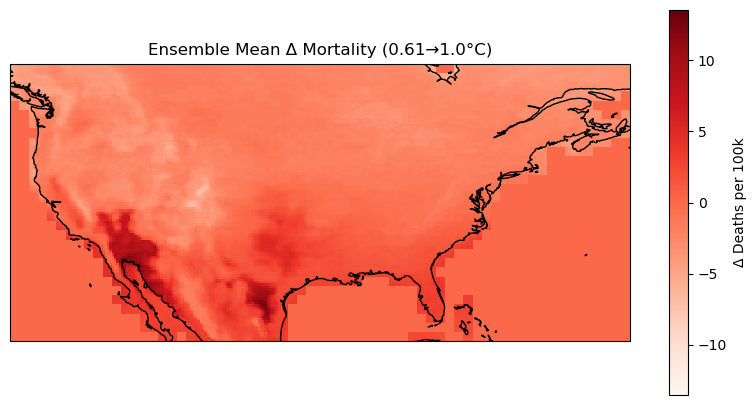

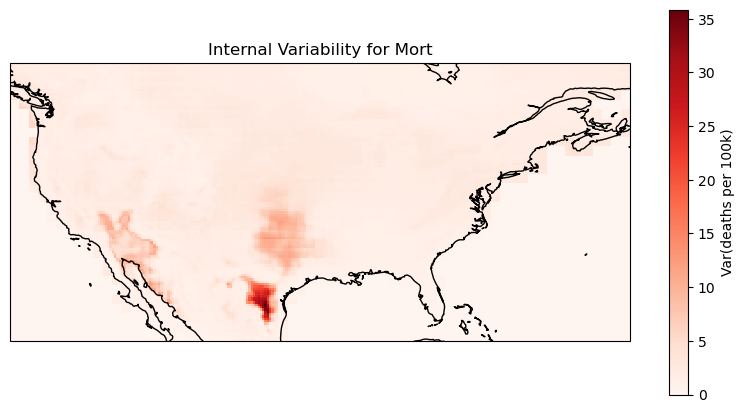

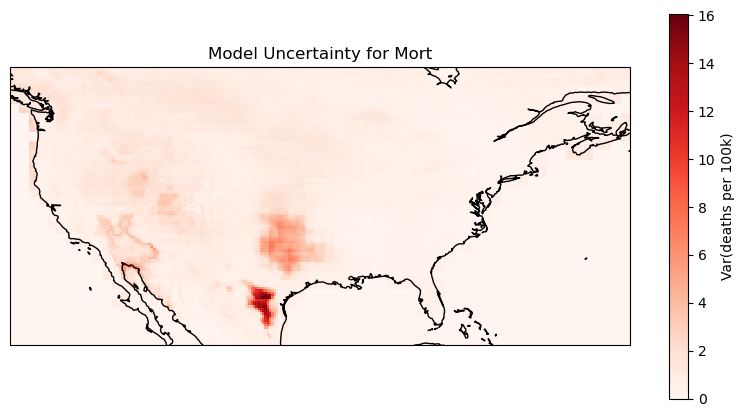

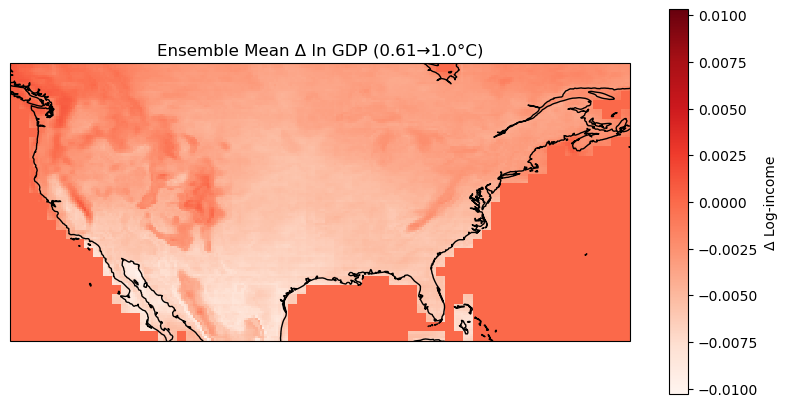

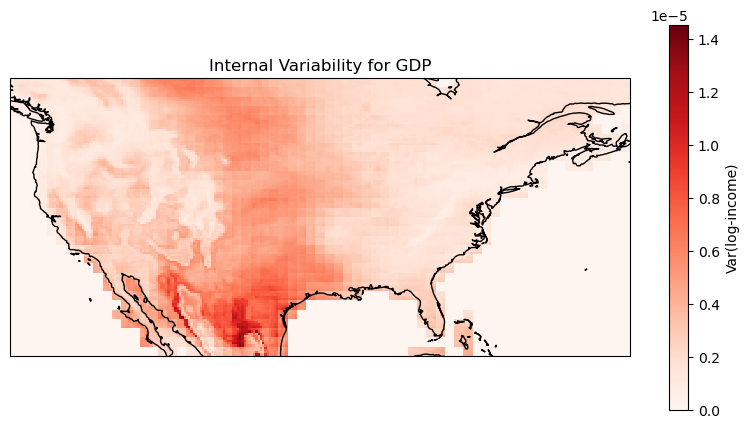

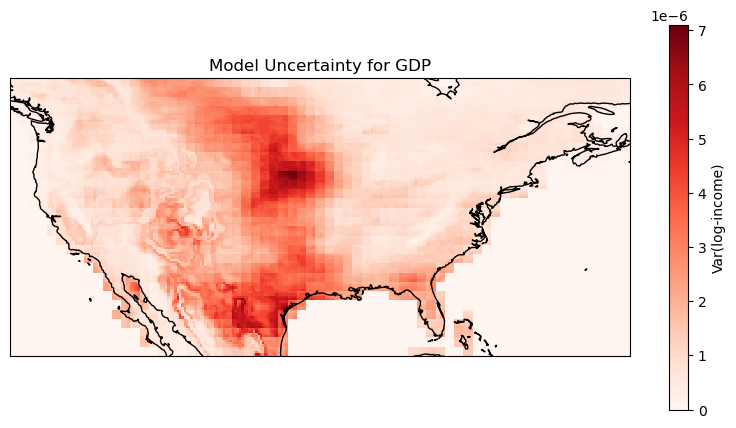

{'mort_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A-LR' ... 'MRI-ESM2-0',
 'gdp_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A

In [102]:
spit_out(1.0)

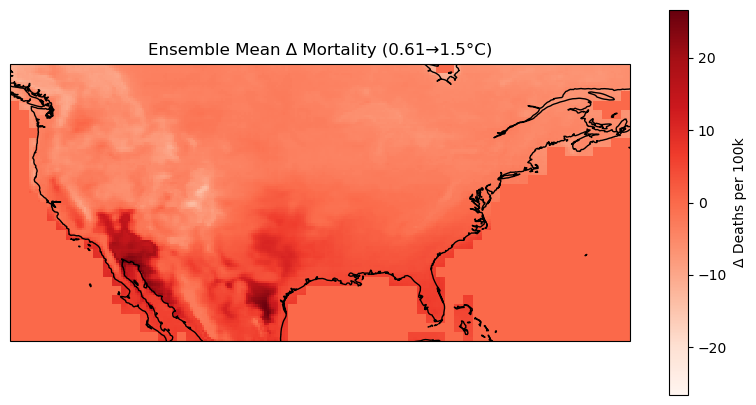

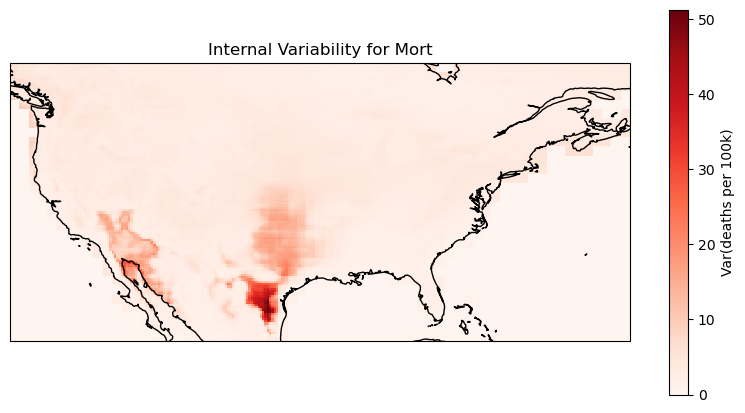

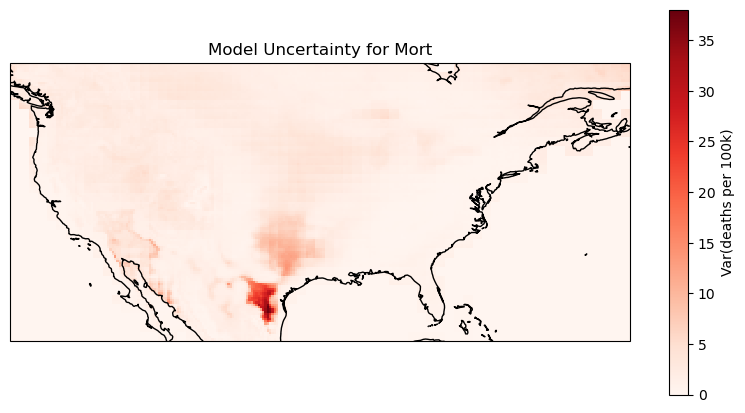

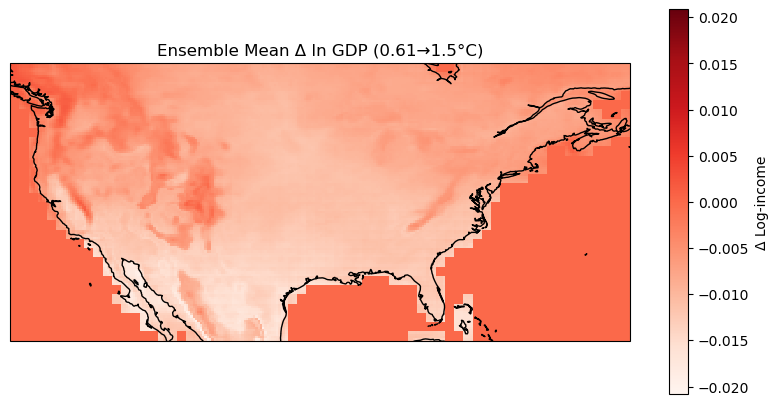

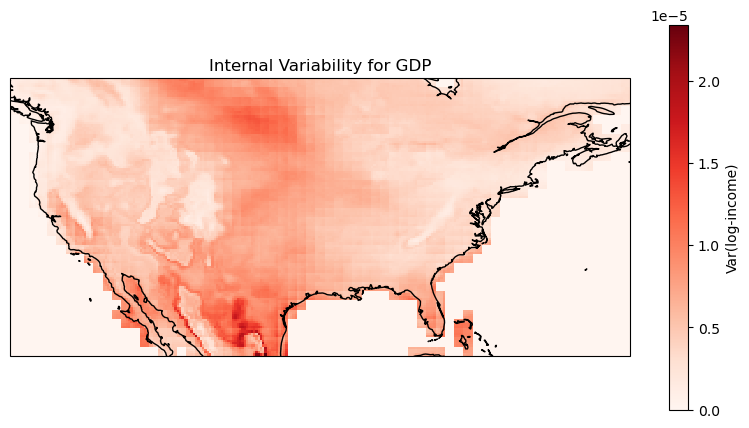

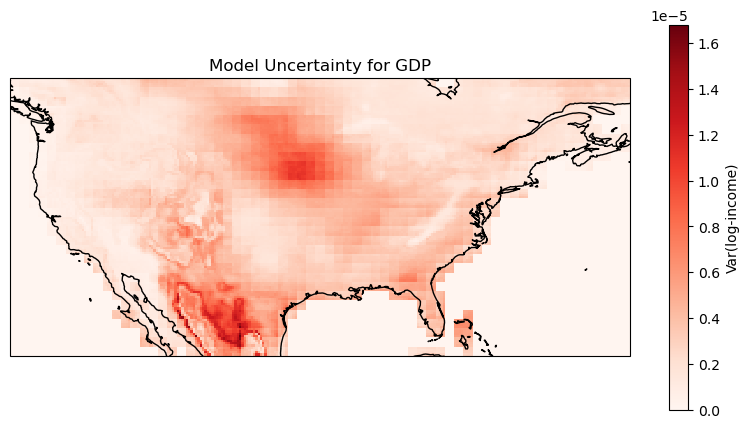

{'mort_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A-LR' ... 'MRI-ESM2-0',
 'gdp_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A

In [15]:
spit_out(1.5)

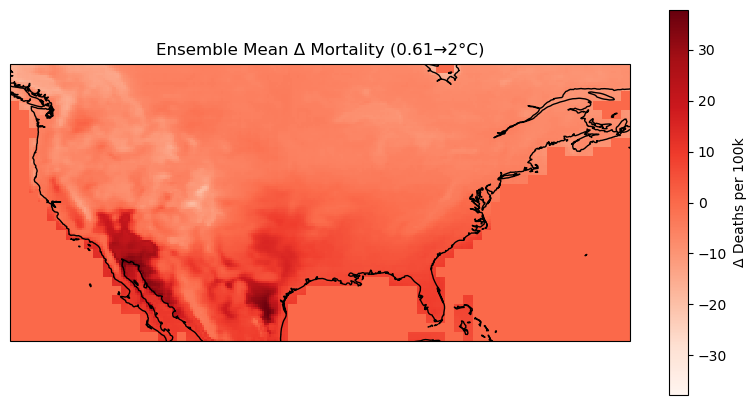

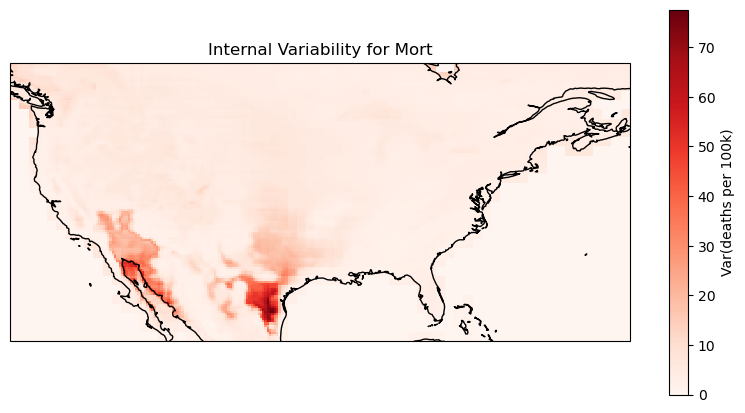

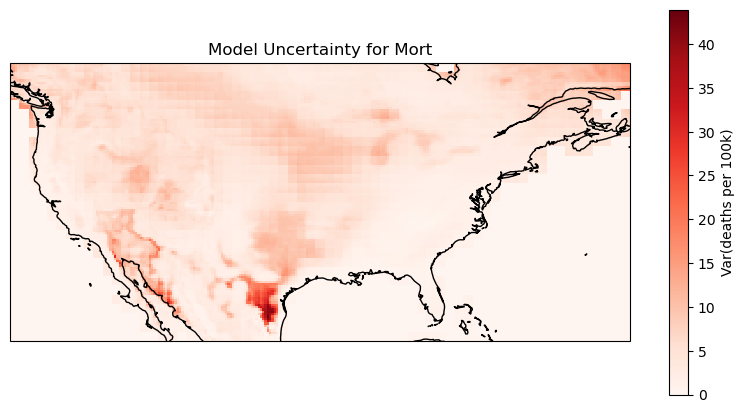

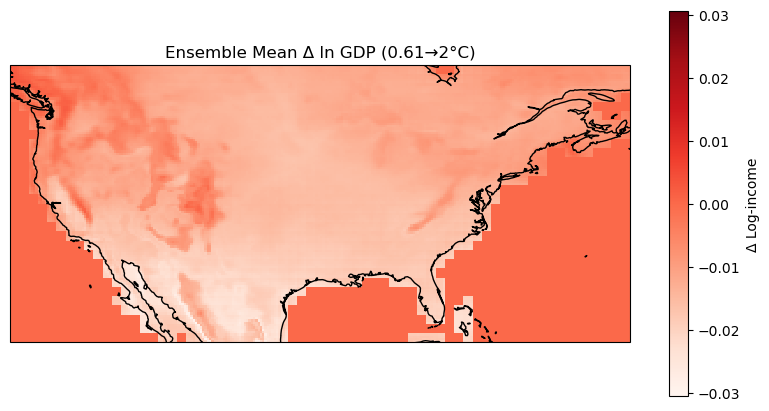

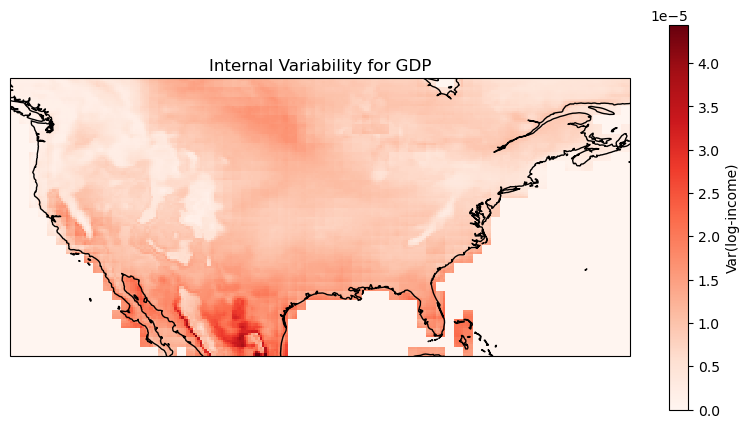

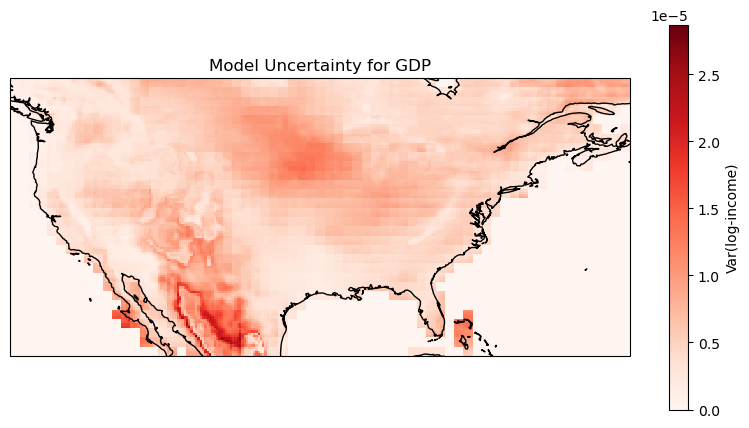

{'mort_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A-LR' ... 'MRI-ESM2-0',
 'gdp_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A

In [16]:
spit_out(2)

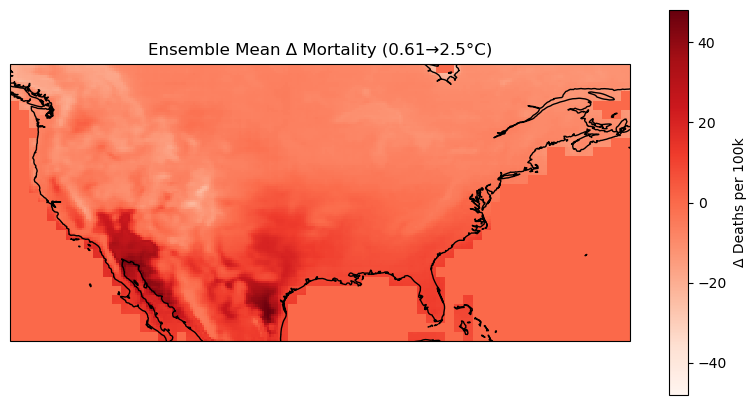

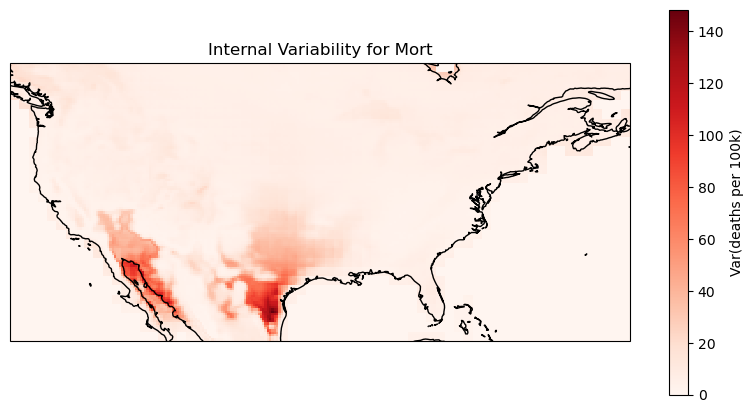

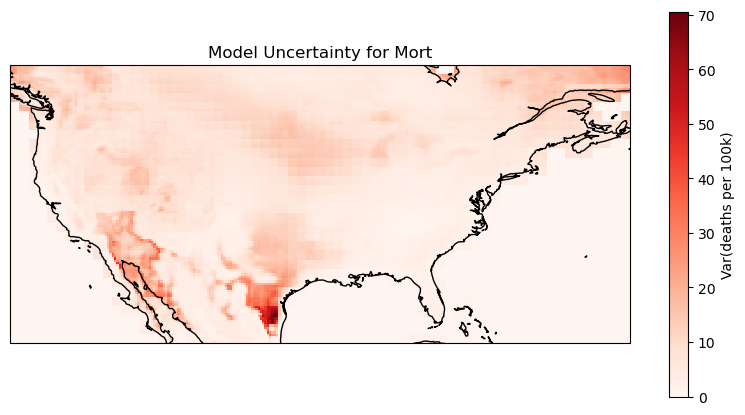

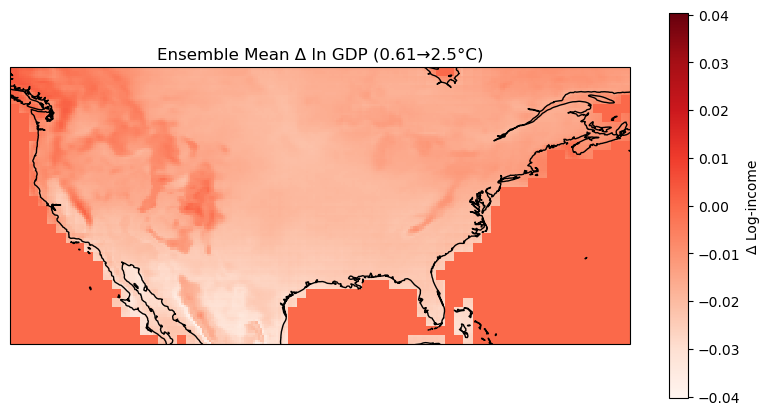

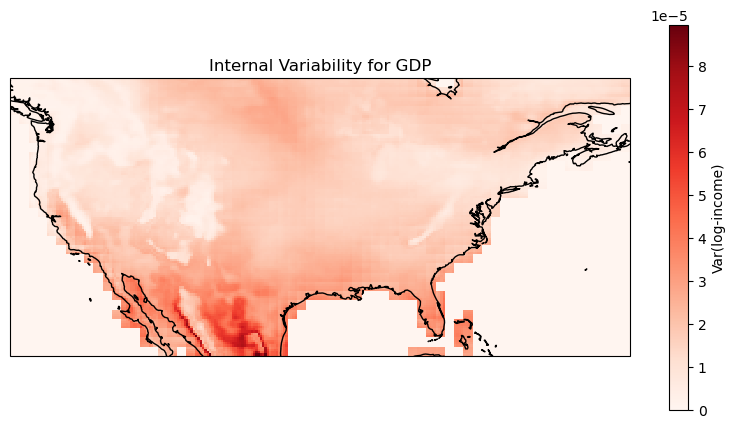

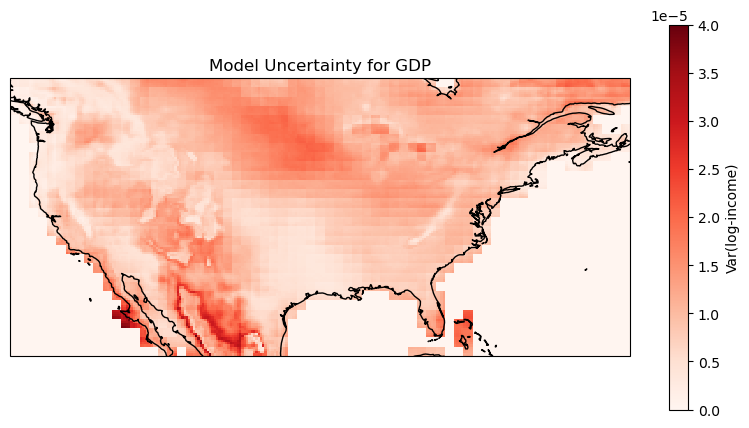

{'mort_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A-LR' ... 'MRI-ESM2-0',
 'gdp_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A

In [17]:
spit_out(2.5)

/apps/anaconda3/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


At GWL 3.0°C:  f_internal = 53.49%,  f_model = 46.51%


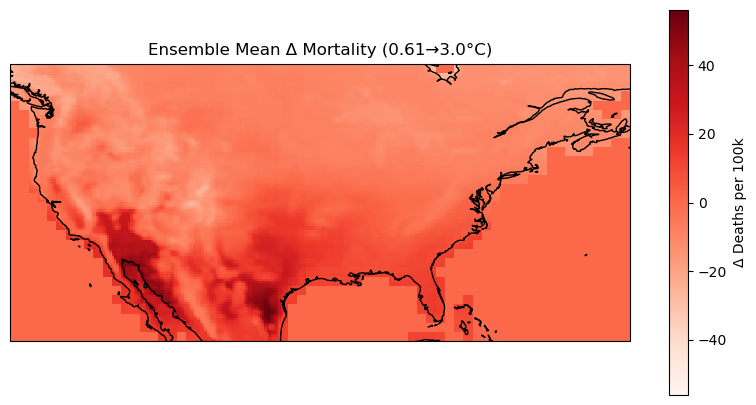

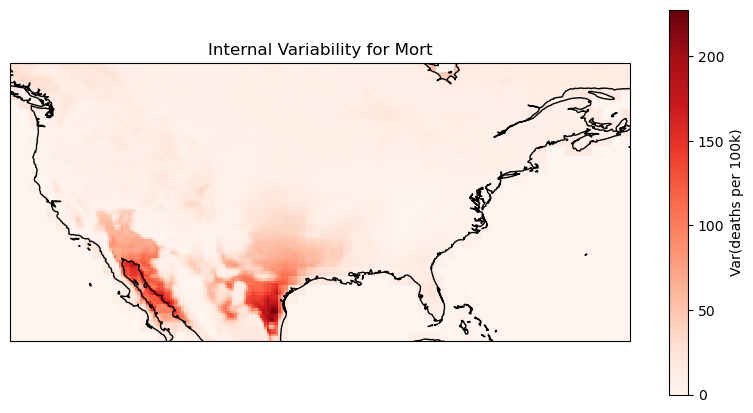

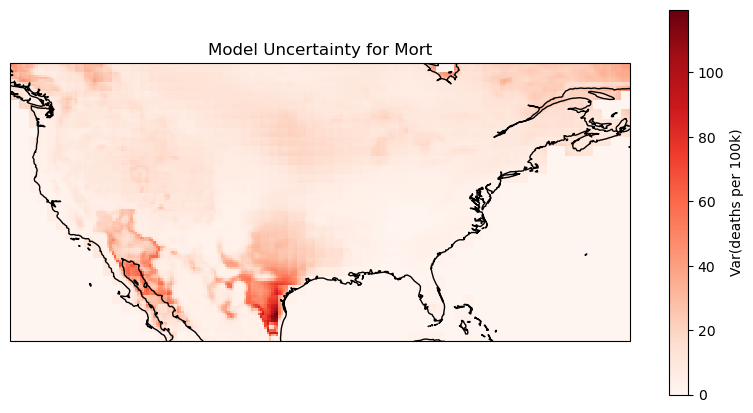

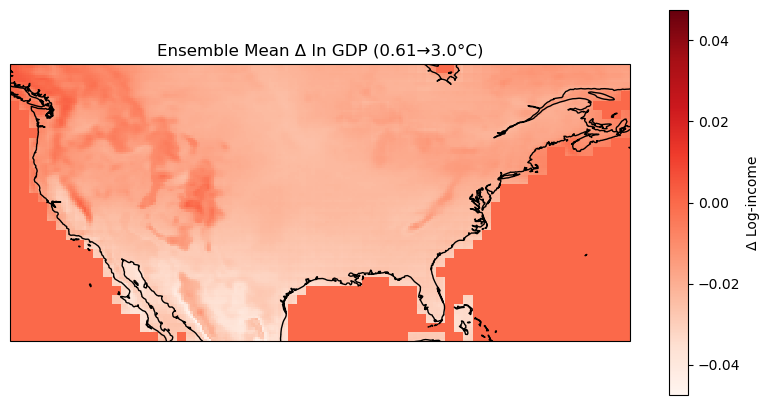

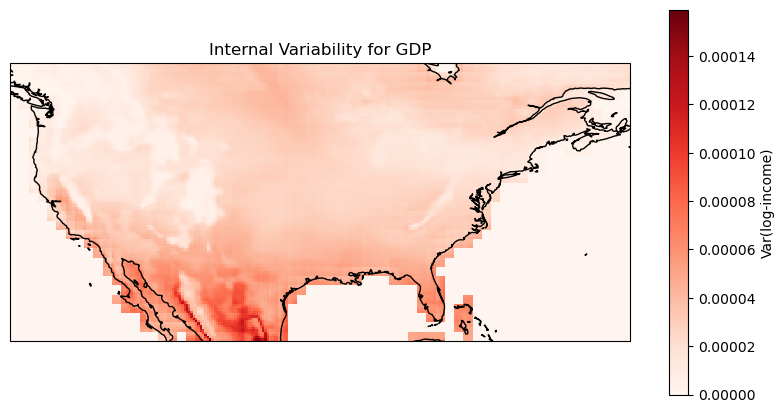

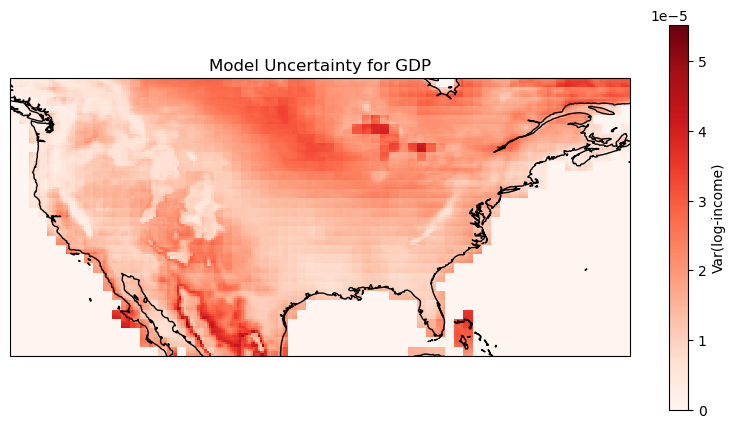

{'mort_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A-LR' ... 'MRI-ESM2-0',
 'gdp_all': <xarray.DataArray (run: 101, lat: 120, lon: 268)> Size: 26MB
 dask.array<concatenate, shape=(101, 120, 268), dtype=float64, chunksize=(1, 120, 268), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
   * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12
   * run      (run) <U9 4kB 'r22i1p1f1' 'r1i1p1f1' ... 'r2i1p1f1' 'r4i1p1f1'
     model    (run) <U13 5kB 'IPSL-CM6A-LR' 'IPSL-CM6A

In [18]:
spit_out(3.0)

In [12]:
def var_table(impact_glob, g):
    internal_var = (impact_glob.groupby("model").var(dim="run", ddof=1).mean(dim="model"))
    model_var = (impact_glob.groupby("model").mean(dim="run").var(dim="model", ddof=1))
    total = internal_var + model_var
    f_int = float((internal_var / total))
    f_mod = float((model_var    / total))

    return {"gwl": g, "f_internal": f_int, "f_model": f_mod}


In [13]:
import pandas as pd

def global_variability_table(gwl_list):
    rows_mort = []
    rows_gdp = []
    for g in gwl_list:
        mort_all, gdp_all = calculate_impact_test(g)

        mort_glob = area_mean(mort_all.to_dataset(name="mort"))["mort"]
        gdp_glob = area_mean(gdp_all.to_dataset(name="gdp"))["gdp"]

        rows_mort.append(var_table(mort_glob, g))
        rows_gdp.append( var_table(gdp_glob,  g))

    mort_df = pd.DataFrame(rows_mort)
    gdp_df  = pd.DataFrame(rows_gdp)
    return mort_df, gdp_df

gwl_list = [1.0, 1.5, 2.0, 2.5, 3.0]
mort_df, gdp_df = global_variability_table(gwl_list)

print("Mortality fractions by GWL:")
print(mort_df)

print("\nGDP fractions by GWL:")
print(gdp_df)


Mortality fractions by GWL:
   gwl  f_internal   f_model
0  1.0    0.579048  0.420952
1  1.5    0.445138  0.554862
2  2.0    0.211905  0.788095
3  2.5    0.189272  0.810728
4  3.0    0.217159  0.782841

GDP fractions by GWL:
   gwl  f_internal   f_model
0  1.0    0.506886  0.493114
1  1.5    0.638786  0.361214
2  2.0    0.695527  0.304473
3  2.5    0.706983  0.293017
4  3.0    0.703837  0.296163
